In [1]:
import math
import numpy as np
import pandas as pd
import torch
import torch.autograd as autograd
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
def kl_divergence(mu1, mu2, sigma_1, sigma_2):
    #sigma_diag_1 = np.eye(sigma_1.shape[0]) * sigma_1
    #sigma_diag_2 = np.eye(sigma_2.shape[0]) * sigma_2

    sigma_2_inv = torch.inverse(sigma_2)

    kl = 0.5 * ((torch.det(sigma_2) / torch.det(sigma_1)).log()
                - sigma_1.shape[0] 
                + torch.trace(torch.matmul(sigma_2_inv, sigma_1))
                + torch.matmul(torch.matmul((mu2 - mu1).reshape(1,-1),
                                            sigma_2_inv),
                               (mu2 - mu1).reshape(-1,1)))

    return kl


def multivariate_gaussian(pos, mu, Sigma):
    """Return the multivariate Gaussian distribution on array pos."""

    n = mu.shape[0]
    Sigma_det = np.linalg.det(Sigma)
    Sigma_inv = np.linalg.inv(Sigma)
    N = np.sqrt((2*np.pi)**n * Sigma_det)
    # This einsum call calculates (x-mu)T.Sigma-1.(x-mu) in a vectorized
    # way across all the input variables.
    fac = np.einsum('...k,kl,...l->...', pos-mu, Sigma_inv, pos-mu)

    return np.exp(-fac / 2) / N





In [3]:
mu_opt = torch.tensor([20.,20])
Sigma_opt = torch.tensor([[100.,0.],[.0,1]])



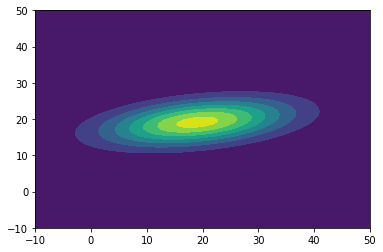

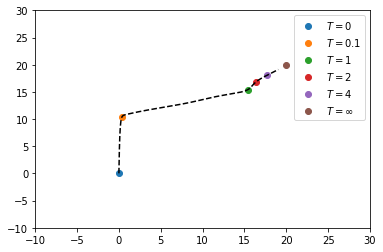

In [4]:
#### SVGD version 0




Sigma_0 = torch.tensor([[1.,.0],[.0,1.]])
X0 = torch.matmul(torch.randn(1000,2),Sigma_0**0.5)

#Sigma_opt = torch.tensor([[100,0],[0,1]])
#Sigma_opt_inv = torch.tensor([[0.01,0],[0,1]])

Sigma_opt_inv = torch.inverse(Sigma_opt)
mu0 = torch.tensor([0.,0])




K = torch.eye(2)
X = X0.clone()
X = X.T
I = torch.eye(2)
N = 100
XX = np.linspace(-10, 50, N)
YY = np.linspace(-10, 50, N)
XX, YY = np.meshgrid(XX, YY)
pos = np.empty(XX.shape + (2,))
pos[:, :, 0] = XX
pos[:, :, 1] = YY
m = np.array([0.,0.]) 

lr = 1e-3
I = torch.eye(2)


cov = Sigma_0.clone()
mu = mu0.clone()

T=10
samples = []
kls = []

H = I
K = I
mu_opt_mu_opt = (mu_opt).reshape(-1,1).matmul((mu_opt).reshape(1,-1))
def covfunc(a,b):
    return (a).reshape(-1,1).matmul((b).reshape(1,-1))


c = mu0

cov1 = cov
for i in range(int(T/lr)):
    cov_inv = torch.inverse(cov)

    A = Sigma_opt_inv.matmul(cov + covfunc(mu-mu_opt,mu-c)).matmul(K)
    
    B = cov_inv.matmul(cov - covfunc(c,mu)+covfunc(mu,c)).matmul(K)
    
    func1 = lambda x:-A.matmul(x-c) + Sigma_opt_inv.matmul(mu_opt-mu)
    func2 = lambda x:B.matmul(x-c)
    
    mu += lr * (func1(mu)+func2(mu))
    

    diff = I + lr*(-A+B)
 

    cov1 = torch.matmul(diff,cov1).matmul(diff.t())
    cov = cov1

    samples.append(mu.clone().numpy())

    
    X = X + lr*((B-A).matmul(X-c.reshape(-1,1)))
    kls.append(kl_divergence(mu, mu_opt, cov, Sigma_opt).numpy())


X = X.T

ZZ = multivariate_gaussian(pos,mu.numpy(),cov.numpy())
plt.figure(111)
plt.contourf(XX,YY,ZZ)

samples = np.array(samples)

plt.figure(0)
plt.plot([0],[0],'o',label=r'$T=0$')


plt.plot(samples[int(0.1/lr),0],samples[int(0.1/lr),1],'o',label=r'$T=0.1$')
plt.plot(samples[int(1/lr),0],samples[int(1/lr),1],'o',label=r'$T=1$')
plt.plot(samples[int(2/lr),0],samples[int(2/lr),1],'o',label=r'$T=2$')
plt.plot(samples[int(4/lr),0],samples[int(4/lr),1],'o',label=r'$T=4$')

plt.plot([20],[20],'o',label=r'$T=\infty$')
plt.plot(samples[:,0],samples[:,1],'--k')
plt.xlim([-10,30])
plt.ylim([-10,30])
plt.legend()

svgd_linear = samples
svgd_linear_kl = np.squeeze(np.array(kls))

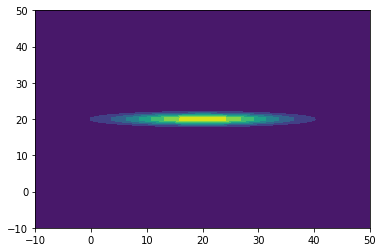

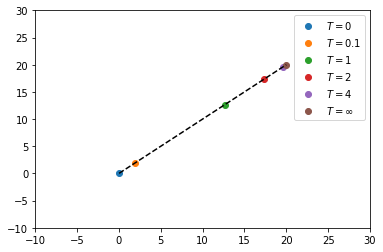

In [5]:

Sigma_0 = torch.tensor([[1.,.0],[.0,1.]])
X0 = torch.matmul(torch.randn(1000,2),Sigma_0**0.5)

#Sigma_opt = torch.tensor([[100,0],[0,1]])
#Sigma_opt_inv = torch.tensor([[0.01,0],[0,1]])
#Sigma_opt = torch.tensor([[100.,0.],[.0,1]])
Sigma_opt_inv = torch.inverse(Sigma_opt)
mu0 = torch.tensor([0.,0])
#mu_opt = torch.tensor([20.,20])



K = torch.eye(2)
X = X0.clone()
X = X.T
I = torch.eye(2)
N = 100
XX = np.linspace(-10, 50, N)
YY = np.linspace(-10, 50, N)
XX, YY = np.meshgrid(XX, YY)
pos = np.empty(XX.shape + (2,))
pos[:, :, 0] = XX
pos[:, :, 1] = YY
m = np.array([0.,0.]) 

lr = 1e-3
I = torch.eye(2)


cov = Sigma_0.clone()
mu = mu0.clone()

T=10
samples = []
kls = []
H = Sigma_opt
K = I
mu_opt_mu_opt = (mu_opt).reshape(-1,1).matmul((mu_opt).reshape(1,-1))
for i in range(int(T/lr)):
    cov_inv = torch.inverse(cov)
    Q = I
    P = H

    Q = I
    PSQ = torch.matmul(P,Sigma_opt_inv).matmul(Q)
    mu += lr*torch.matmul(PSQ,mu_opt-mu)
    
    diff = I + lr*(torch.matmul(P,cov_inv).matmul(Q)-PSQ)
    
    cov = torch.matmul(diff,cov).matmul(diff.t())
    samples.append(mu.clone().numpy())

    kls.append(kl_divergence(mu, mu_opt, cov, Sigma_opt).numpy())


plt.figure(0)

ZZ = multivariate_gaussian(pos,mu.numpy(),cov.numpy())

plt.contourf(XX,YY,ZZ)

plt.figure(1)

samples = np.array(samples)
plt.plot([0],[0],'o',label=r'$T=0$')
plt.plot(samples[int(0.1/lr),0],samples[int(0.1/lr),1],'o',label=r'$T=0.1$')
plt.plot(samples[int(1/lr),0],samples[int(1/lr),1],'o',label=r'$T=1$')
plt.plot(samples[int(2/lr),0],samples[int(2/lr),1],'o',label=r'$T=2$')
plt.plot(samples[int(4/lr),0],samples[int(4/lr),1],'o',label=r'$T=4$')
plt.plot([20],[20],'o',label=r'$T=\infty$')
plt.plot(samples[:,0],samples[:,1],'--k')
plt.xlim([-10,30])
plt.ylim([-10,30])
plt.legend()

ours = samples
ours_kl = np.squeeze(np.array(kls))

In [6]:
class SVGD:
  def __init__(self, P, K, optimizer):
    self.P = P
    self.K = K
    self.optim = optimizer

  def phi(self, X):
    X = X.detach().requires_grad_(True)

    log_prob = self.P.log_prob(X)
    score_func = autograd.grad(log_prob.sum(), X)[0]

    K_XX = self.K(X, X.detach())
    #score_func = autograd.grad(log_prob.sum(), X)[0]
    grad_K = -autograd.grad(K_XX.sum(), X)[0]

    phi = (K_XX.detach().matmul(score_func) + grad_K) / X.size(0)

    return phi

  def step(self, X):
    self.optim.zero_grad()
    X.grad = -self.phi(X)
    self.optim.step()

    
class RBF(torch.nn.Module):
  def __init__(self, sigma=None):
    super(RBF, self).__init__()

    self.sigma = sigma

  def forward(self, X, Y):
    XX = X.matmul(X.t())
    XY = X.matmul(Y.t())
    YY = Y.matmul(Y.t())

    dnorm2 = -2 * XY + XX.diag().unsqueeze(1) + YY.diag().unsqueeze(0)

    # Apply the median heuristic (PyTorch does not give true median)
    if self.sigma is None:
      np_dnorm2 = dnorm2.detach().cpu().numpy()
      h = np.median(np_dnorm2) / (2 * np.log(X.size(0) + 1))
      sigma = np.sqrt(h).item()
    else:
      sigma = self.sigma

    gamma = 1.0 / (1e-8 + 2 * sigma ** 2)
    K_XY = (-gamma * dnorm2).exp()

    return K_XY
  
# Let us initialize a reusable instance right away.




In [7]:
X_init = torch.randn([1000,2])

gauss = torch.distributions.MultivariateNormal(mu_opt,
        covariance_matrix=Sigma_opt)

In [8]:
K = RBF(1)
X = X_init.clone()
lr = 1e-2
svgd = SVGD(gauss, K, optim.SGD([X], lr=lr))
samples = []
kls = []
for _ in range(int(10/lr)):
    mu = X.mean(0).clone()
    cov = torch.cov(X.t())
    samples.append(mu.numpy())
    svgd.step(X)
    
    kls.append(kl_divergence(mu, mu_opt, cov, Sigma_opt).numpy())

svgd_rbf = samples
svgd_rbf_kl = np.squeeze(np.array(kls))
    




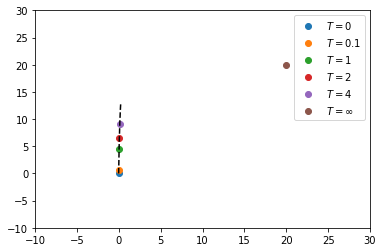

In [9]:
plt.figure(1)

samples = np.array(samples)
plt.plot([0],[0],'o',label=r'$T=0$')
plt.plot(samples[int(0.1/lr),0],samples[int(0.1/lr),1],'o',label=r'$T=0.1$')
plt.plot(samples[int(1/lr),0],samples[int(1/lr),1],'o',label=r'$T=1$')
plt.plot(samples[int(2/lr),0],samples[int(2/lr),1],'o',label=r'$T=2$')
plt.plot(samples[int(4/lr),0],samples[int(4/lr),1],'o',label=r'$T=4$')
plt.plot([20],[20],'o',label=r'$T=\infty$')
plt.plot(samples[:,0],samples[:,1],'--k')
plt.xlim([-10,30])
plt.ylim([-10,30])
plt.legend()




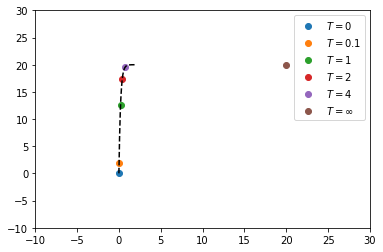

In [10]:

Sigma_0 = torch.tensor([[1.,.0],[.0,1.]])
X0 = torch.matmul(torch.randn(1000,2),Sigma_0**0.5)


Sigma_opt_inv = torch.inverse(Sigma_opt)
mu0 = torch.tensor([0.,0])

K = torch.eye(2)
X = X0.clone()
X = X.T
I = torch.eye(2)
N = 100
XX = np.linspace(-10, 50, N)
YY = np.linspace(-10, 50, N)
XX, YY = np.meshgrid(XX, YY)
pos = np.empty(XX.shape + (2,))
pos[:, :, 0] = XX
pos[:, :, 1] = YY
m = np.array([0.,0.]) 

lr = 1e-3
I = torch.eye(2)


cov = Sigma_0.clone()
mu = mu0.clone()

T=10
samples = []
kls = []
H = I
K = I
mu_opt_mu_opt = (mu_opt).reshape(-1,1).matmul((mu_opt).reshape(1,-1))

for i in range(int(T/lr)):
    cov_inv = torch.inverse(cov)

    K = cov_inv

    P = H
    
  
    Q = torch.matmul(cov,K)
    PSQ = torch.matmul(P,Sigma_opt_inv).matmul(Q)
    mu += lr*torch.matmul(PSQ,mu_opt-mu)
    
    diff = I + lr*(torch.matmul(P,cov_inv).matmul(Q)-PSQ)
    
    cov = torch.matmul(diff,cov).matmul(diff)
    samples.append(mu.clone().numpy())
    kls.append(kl_divergence(mu, mu_opt, cov, Sigma_opt).numpy())




samples = np.array(samples)
plt.plot([0],[0],'o',label=r'$T=0$')
plt.plot(samples[int(0.1/lr),0],samples[int(0.1/lr),1],'o',label=r'$T=0.1$')
plt.plot(samples[int(1/lr),0],samples[int(1/lr),1],'o',label=r'$T=1$')
plt.plot(samples[int(2/lr),0],samples[int(2/lr),1],'o',label=r'$T=2$')
plt.plot(samples[int(4/lr),0],samples[int(4/lr),1],'o',label=r'$T=4$')
plt.plot([20],[20],'o',label=r'$T=\infty$')
plt.plot(samples[:,0],samples[:,1],'--k')
plt.xlim([-10,30])
plt.ylim([-10,30])
plt.legend()

w_grad = samples
w_grad_kl = np.squeeze(np.array(kls))

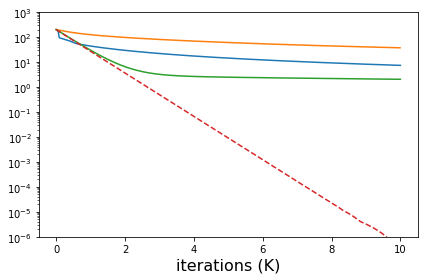

In [11]:
plt.plot(np.arange(len(svgd_linear_kl))/1000,svgd_linear_kl,label='SVGD (Linear)')
plt.plot(np.arange(len(svgd_rbf_kl))*10/1000,svgd_rbf_kl,label='SVGD (RBF)')
plt.plot(np.arange(len(w_grad_kl))/1000,w_grad_kl,label='Wasserstein Grad')
plt.plot(np.arange(len(ours_kl))/1000,ours_kl,'--',label='Ours')
plt.xlabel('iterations (K)',fontsize=16)
plt.ylabel('KL divergence',fontsize=30)
plt.ylim([1e-6,1e3])
#plt.ylim([1e-6,1e2])
#plt.ylim([1e-6,2e0])
plt.yscale('log')
plt.tight_layout()

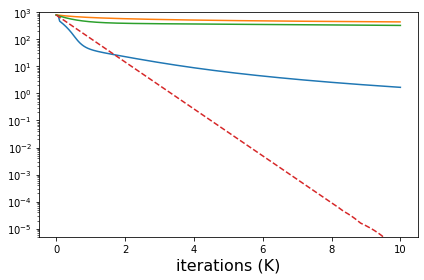

In [12]:
def dist_f(x):
    return np.sum((x-mu_opt.numpy().reshape(1,-1))**2,1)

#plt.figure(figsize=(5,3))



plt.plot(np.arange(len(svgd_linear_kl))/1000,dist_f(svgd_linear),label='SVGD (Linear)')
plt.plot(np.arange(len(svgd_rbf))*10/1000,dist_f(svgd_rbf),label='SVGD (RBF)')
plt.plot(np.arange(len(w_grad_kl))/1000,dist_f(w_grad),label='Wasserstein Grad')
plt.plot(np.arange(len(ours_kl))/1000,dist_f(ours),'--',label='Ours')
plt.xlabel('iterations (K)',fontsize=16)
plt.ylabel('$\Vert\mu_t - \mu_*\Vert^2$',fontsize=30)
plt.ylim([5e-6,1e3])
#plt.ylim([5e-6,5e0])
#plt.legend()
plt.yscale('log')
#plt.legend(fontsize=13,loc='lower left')
plt.tight_layout()